In [1]:
import numpy as np
import helpers
import pandas as pd
import seaborn as sns
import helpers
%pylab inline
import matplotlib.pyplot as plt
from w2v import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition as dcmp
from sklearn.metrics import log_loss

Populating the interactive namespace from numpy and matplotlib


In [2]:
X1, y1 = helpers.get_training('./data/training_variants', './data/training_text')
X2, y2 = helpers.get_test('./data/training_variants', './data/training_text')

In [4]:
X_text = pd.concat([X1, X2]).Text
y = pd.concat([y1, y2])
y_train = y.Class
X_genes = y.Gene
X_variants = y.Variation
gene_vocab = X_genes.unique()
variant_vocab = X_variants.unique()
X_text_unique = X_text.unique()
variantVectorizer=CountVectorizer(vocabulary=variant_vocab, lowercase=False)
variantData = variantVectorizer.transform(X_text_unique).toarray()
geneVectorizer=CountVectorizer(vocabulary=gene_vocab, lowercase=False)
geneData = geneVectorizer.transform(X_text_unique).toarray()

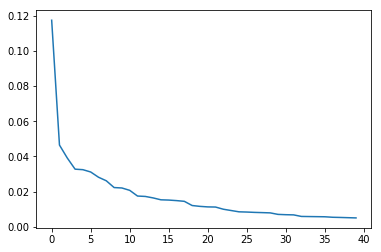

In [5]:
dimension = 40
pca_variants = dcmp.PCA(n_components = dimension)
pca_variants.fit(variantData)
plt.plot(pca_variants.explained_variance_ratio_)

In [105]:
X_variants_reduced = pca_variants.transform(variantVectorizer.transform(X_text).toarray())
X_w2v = np.load('./data/w2v_train_features.npy')
X_total = np.concatenate((X_w2v, X_variants_reduced),axis=1)

In [119]:
clf = train_svm(X_total, y_train)

In [121]:
y_train_prob = clf.predict_proba(X_total)

In [122]:
log_loss(y_train, y_train_prob)

1.3327934193662707

# w2v only

In [12]:
X_w2v = np.load('./data/w2v_train_features.npy')
clf_w2v = train_svm(X_w2v, y_train)
log_loss(y_train, clf_w2v.predict_proba(X_w2v))

1.0885489133301343

# variants + w2v pca

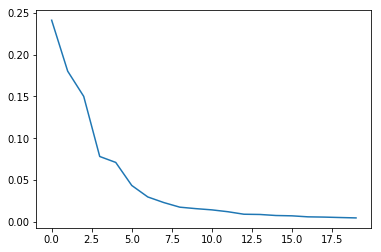

In [13]:
X_variants_reduced = pca_variants.transform(variantVectorizer.transform(X_text).toarray())
dimension = 20
pca_w2v = dcmp.PCA(n_components = dimension)
pca_w2v.fit(X_w2v)
plt.plot(pca_w2v.explained_variance_ratio_)

In [134]:
X_w2v_reduced = pca_w2v.transform(X_w2v)
X_total_recued = np.concatenate((X_w2v_reduced, X_variants_reduced/5.), axis=1)
clf_w2v_reduced = train_svm(X_total_recued, y_train)
log_loss(y_train, clf_w2v_reduced.predict_proba(X_total_recued))

1.3245135786398379

# variants only

In [15]:
clf_variants = train_svm(X_variants_reduced/5., y_train)
log_loss(y_train, clf_variants.predict_proba(X_variants_reduced/5.))

1.6491593275809515

# ensembling predictions of variants + w2v

In [16]:
w2v_proba = clf_w2v.predict_proba(X_w2v)
var_proba = clf_variants.predict_proba(X_variants_reduced/5.)

In [142]:
X_ensemble = np.concatenate((w2v_proba, var_proba), axis=1)
clf_ensemble = train_svm(X_ensemble, y_train)
log_loss(y_train, clf_ensemble.predict_proba(X_ensemble))

1.0457777232067744

# adding in genes as well

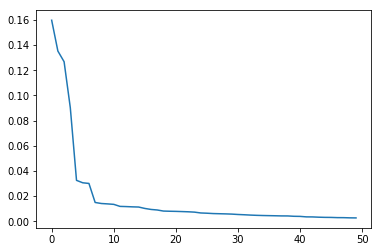

In [6]:
pca_genes = dcmp.PCA(n_components = 50)
pca_genes.fit(geneData)
plt.plot(pca_genes.explained_variance_ratio_)
X_genes_reduced = pca_genes.transform(geneVectorizer.transform(X_text).toarray())

In [11]:
k = np.sqrt(np.mean(np.square(X_genes_reduced)))
clf_genes = train_svm(X_genes_reduced/k, y_train)
log_loss(y_train, clf_genes.predict_proba(X_genes_reduced/k))

1.4239098916153585

In [17]:
gene_proba = clf_genes.predict_proba(X_genes_reduced/k)

In [20]:
X_ensemble = np.concatenate((w2v_proba, var_proba,gene_proba), axis=1)
clf_ensemble = train_svm(X_ensemble, y_train)
log_loss(y_train, clf_ensemble.predict_proba(X_ensemble))

1.0127330146354843

In [24]:
helpers.kfold_score(clf_ensemble, X_ensemble, y_train.values, splits=5)

1.0346275191476901

In [26]:
helpers.kfold_score(clf_w2v, X_w2v, y_train.values, splits=5)

1.2442857036544914

# submission stuff

In [28]:
test_data = pd.read_csv("./data/test_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
test_text = test_data.Text

In [33]:
test_data = pd.read_csv("./data/test_variants")
test_gene = test_data.Gene
test_variant = test_data.Variation

In [35]:
X_w2v_test = np.load('./data/w2v_test_features.npy')

In [ ]:
X_variants_test = pca_variants.transform(variantVectorizer.transform(test_text).toarray())

In [ ]:
X_genes_test = pca_genes.transform(geneVectorizer.transform(test_text).toarray())